### Simulation SGD for titanic data

In [2]:
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt
import numpy as np
import mmh3
import time

import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
# csv_row must be dict
def get_x_mmh3(csv_row, D):
    x = [0]
    for key, value in csv_row.items():
        index = mmh3.hash128(str(key) + str(value), seed=rand_seed, x64arch=True) % D
        x.append(index)
    return x

In [4]:
def get_p(x, w):
    wTx = 0.
    for i in x:  # do wTx
        wTx += w[i] * 1.  # w[i] * x[i], but if i in x we got x[i] = 1.
    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid

In [5]:
def update_w_withn(w, n, x, p, y):
    for i in x:
        w[i] -= (p - y) * alpha / (sqrt(n[i]) + 1.)
        n[i] += 1.
    return w, n

In [6]:
def update_w(w, n, x, p, y):
    for i in x:
        w[i] -= (p - y) * alpha
        n[i] += 1.
    return w, n

In [7]:
def logloss(p, y):
    p = max(min(p, 1. - 10e-12), 10e-12)
    return -log(p) if y == 1. else -log(1. - p)

###### Start trainning

In [8]:
#train = r'C:/Temp/titanic/train.csv'
#test = r'C:/Temp/titanic/test.csv'
train = r'C:/My/Playground/Git/2016_Thesis/100_Simulation/data/train.csv'
test = r'C:/My/Playground/Git/2016_Thesis/100_Simulation/data/test.csv'

#train = r'E:/PlayGround/Github/2016_thesis/100_Simulation/data/train.csv'
#test = r'E:/PlayGround/Github/2016_thesis/100_Simulation/data/test.csv'

header = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin' , 'Embarked']

D = 2 ** 10
#alpha = 1.# learning rate for sgd optimization
alpha = 0.25    # learning rate for sgd optimization

w = [0.] * D  # weights
n = [0.] * D  # number of times we've encountered a feature

rand_seed = 1004

In [9]:
# Test variables
DEBUG = True
num_check_point_print = 100
num_check_point_log_loss = 1
#num_finish_point = 2
ts = ''

In [12]:
n = np.array([0.] * (D))
log_loss_sgd_training = 0.
arr_log_loss_sgd_training = []

start_time = time.time()

n_iter = 0.
with open(train) as tit_file:
    tit_raw = DictReader(tit_file, fieldnames=header, delimiter=',');
    for t, row in enumerate(tit_raw):
        if t != 0: # Skipping header
            #print('t: ', t, ' row: ', row) # test
            y = 1. if row['Survived'] == '1' else 0.
            del row['Survived']
            del row['PassengerId']
            
            x = get_x_mmh3(row, D)

            p = get_p(x, w)
            
            log_loss_sgd_training += logloss(p, y)
            
            #w, n = update_w(w, n, x, p, y)
            w, n = update_w_withn(w, n, x, p, y)

            if t % num_check_point_print == 0 and t > 1:
                print('%s\tencountered: %d\t y=%d: %f, loss/t:%f' % (
                    datetime.now(), (t), y, p, log_loss_sgd_training/t))

            if t % num_check_point_log_loss == 0 and t > 1:
                arr_log_loss_sgd_training.append(get_validation_error(w))
            
            n_iter += 1.
            
            if t == 800:
                break

print("---Total execution time: %s seconds ---" % (time.time() - start_time))

2016-05-08 21:59:45.437000	encountered: 100	 y=0: 0.249879, loss/t:0.525220
2016-05-08 21:59:46.594000	encountered: 200	 y=0: 0.626326, loss/t:0.510985
2016-05-08 21:59:47.925000	encountered: 300	 y=1: 0.717094, loss/t:0.523617
2016-05-08 21:59:49.106000	encountered: 400	 y=1: 0.714368, loss/t:0.497885
2016-05-08 21:59:50.046000	encountered: 500	 y=0: 0.157430, loss/t:0.495172
2016-05-08 21:59:50.944000	encountered: 600	 y=1: 0.478412, loss/t:0.489198
2016-05-08 21:59:52.210000	encountered: 700	 y=0: 0.128704, loss/t:0.483414
2016-05-08 21:59:53.163000	encountered: 800	 y=0: 0.548962, loss/t:0.476448
---Total execution time: 8.79800009727 seconds ---


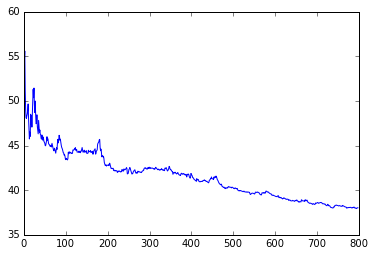

In [13]:
%matplotlib inline


def plot_log_loss(arr_log_loss):
    x = range(len(arr_log_loss))
    plt.plot(x, arr_log_loss, label='log_loss')
    
plot_log_loss(arr_log_loss_sgd_training)



###### Validate with test set

In [222]:
start_time = time.time()

log_loss_sgd_test = 0.
n_iter = 0.
n_TP = 0.
with open(train) as tit_file:
    tit_raw = DictReader(tit_file, fieldnames=header, delimiter=',');
    for t, row in enumerate(tit_raw):
        if t > 800:
            y = 1. if row['Survived'] == '1' else 0.
            del row['Survived']
            
            x = get_x_mmh3(row, D)
            
            p = get_p(x, w)

            log_loss_sgd_test += logloss(p, y)
            
            if t % 100 == 0 and t > 1:
                print('%s\tencountered: %d\t y=%d: %f, loss:%f' % (
                    datetime.now(), (t), y, p, log_loss_sgd_test/t))
            
            
            n_iter += 1
            if y == 1:
                if p >= 0.5:
                    n_TP += 1.
            else:
                if p < 0.5:
                    n_TP += 1.
            
print("---Total execution time: %s seconds ---" % (time.time() - start_time))
print(n_TP, n_iter)
print("Prediction ratio: ", n_TP / n_iter)
print("log-loss: ", log_loss_sgd_test)

---Total execution time: 0.0230000019073 seconds ---
(75.0, 91.0)
('Prediction ratio: ', 0.8241758241758241)
('log-loss: ', 38.19091681426671)


In [223]:
get_validation_error(w)

38.19091681426671

In [11]:
# Validation function
def get_validation_error(w):
    start_time = time.time()

    log_loss = 0.
    n_iter = 0.
    n_TP = 0.

    with open(train) as tit_file:
        tit_raw = DictReader(tit_file, fieldnames=header, delimiter=',');
        for t, row in enumerate(tit_raw):
            if t > 800:
                y = 1. if row['Survived'] == '1' else 0.
                del row['Survived']

                x = get_x_mmh3(row, D)

                p = get_p(x, w)

                log_loss += logloss(p, y)

                n_iter += 1
                if y == 1:
                    if p >= 0.5:
                        n_TP += 1.
                else:
                    if p < 0.5:
                        n_TP += 1.

    # print("---Total execution time: %s seconds ---" % (time.time() - start_time))
    return(log_loss)


---

### Simulation ADF for titanicdata from v016

In [225]:
from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt
import numpy as np
import mmh3
import time
from spooky import hash128, hash64, hash32

In [226]:
# csv_row must be dict
def get_x_mmh3(csv_row, D):
    x = [0]
    for key, value in csv_row.items():
        index = mmh3.hash128(str(key) + str(value), seed=rand_seed, x64arch=True) % D
        x.append(index)
    return x

In [227]:
# csv_row must be dict
def get_x_spooky(csv_row, D):
    x = [0]
    for key, value in csv_row.items():
        index = hash32(str(key) + str(value)) % D
        x.append(index)
    return x

In [228]:
# w must be numpy ndarray
def get_p_cat(x, w):
    wTx = sum(w[x])
    return 1. / (1. + exp(-max(min(wTx, 20.), -20.)))  # bounded sigmoid

In [229]:
# s_t_m_old and s_t_v_old must be numpy ndarray
def get_s_t_new(y, s_t_m_old, s_t_v_old):

    wi = wwi / np.sqrt(np.pi)
    xi = xxi * np.sqrt(2) * np.sqrt(s_t_v_old) + s_t_m_old
    
    fw = 0.
    if(y==1.):
        fw = (1. / (1. + np.exp(-xi))) * wi
    else:
        fw = ((np.exp(-xi)) / (1. + np.exp(-xi))) * wi

    z_t = sum(fw)
    s_t_m_new = 1. / z_t * sum(xi * fw)
    s_t_v_new = 1. / z_t * sum((xi**2) * fw) - s_t_m_new**2
        
    return (s_t_m_new, s_t_v_new)

In [230]:
# theta_t_v must be numpy ndarray
def get_a_i_cat(x, theta_t_v):
    return theta_t_v[x] / sum(theta_t_v[x])

In [231]:
def update_theta_cat(x, theta_t_m, theta_t_v, delta_m, delta_v, n_iter):
    a_i = get_a_i_cat(x, theta_t_v)
    theta_t_m[x] += (a_i * delta_m) #92.5
    #theta_t_v[x] += ((a_i**2) * delta_v) #+ abs(theta_t_m[x])/min((n_iter+1.), 3000.)
    #theta_t_v[x] += ((a_i**2) * delta_v) + np.exp(-abs(theta_t_m[x])) / min((n_iter+10.), 3000.)
    theta_t_v[x] += ((a_i**2) * delta_v)
    n[x] += 1.

In [232]:
def logloss(p, y):
    p = max(min(p, 1. - 10e-12), 10e-12)
    return -log(p) if y == 1. else -log(1. - p)

**Start trainning**

In [233]:
#train = r'C:/Temp/titanic/train.csv'
#test = r'C:/Temp/titanic/test.csv'
train = r'C:/My/Playground/Git/2016_Thesis/100_Simulation/data/train.csv'
test = r'C:/My/Playground/Git/2016_Thesis/100_Simulation/data/test.csv'

#train = r'E:/PlayGround/Github/2016_thesis/100_Simulation/data/train.csv'
#test = r'E:/PlayGround/Github/2016_thesis/100_Simulation/data/test.csv'


submission_dir = r'D:/9000_etc/Thesis/data/submission'

header = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin' , 'Embarked']

D = 2 ** 10
n = np.array([0.] * D)
rand_seed = 10

In [234]:
# Test variables
DEBUG = True
num_check_point_print = 100
num_check_point_log_loss = 1
#num_finish_point = 2
ts = ''

In [235]:
num_poly = 10
xxi, wwi = np.polynomial.hermite.hermgauss(num_poly)

theta_t_m = np.array([0.] * D) # mean of thetas at t
theta_t_v = np.array([.2] * D) # variance of thetas at t
n = np.array([0.] * D)

log_loss_adf_training = 0.
arr_log_loss_adf_training = []


start_time = time.time()

n_iter = 0.
with open(train) as tit_file:
    tit_raw = DictReader(tit_file, fieldnames=header, delimiter=',');
    for t, row in enumerate(tit_raw):
        if t != 0: # Skipping header
            #print('t: ', t, ' row: ', row) # test
            y = 1. if row['Survived'] == '1' else 0.
            del row['Survived']
            x = get_x_mmh3(row, D)
            #x = get_x_spooky(row, D)

            # Predictive distribution for s_t ~ N(s_t_m_old, s_t_v_old)
            s_t_m_old = sum(theta_t_m[x])
            s_t_v_old = sum(theta_t_v[x])

            # Posterior distribution for s_t
            s_t_m, s_t_v = get_s_t_new(y, s_t_m_old, s_t_v_old)

            # Changes in s_t
            delta_m = s_t_m - s_t_m_old
            delta_v = s_t_v - s_t_v_old

            # Updating theta
            update_theta_cat(x, theta_t_m, theta_t_v, delta_m, delta_v, t)

            p = get_p_cat(x, theta_t_m)
            
            log_loss_adf_training += logloss(p, y)
            
            
            if t % num_check_point_print == 0 and t > 1:
                print('%s\tencountered: %d\t y=%d: %f, loss/t:%f' % (
                    datetime.now(), (t), y, p, log_loss_adf_training/t))

            if t % num_check_point_log_loss == 0 and t > 1:
                arr_log_loss_adf_training.append(get_validation_error(theta_t_m))
            
            n_iter += 1.
            if t == 800:
                break

print("---Total execution time: %s seconds ---" % (time.time() - start_time))

2016-04-13 23:12:43.842000	encountered: 100	 y=0: 0.197274, loss/t:0.324269
2016-04-13 23:12:44.785000	encountered: 200	 y=0: 0.630685, loss/t:0.326351
2016-04-13 23:12:45.839000	encountered: 300	 y=1: 0.840230, loss/t:0.350855
2016-04-13 23:12:47.231000	encountered: 400	 y=1: 0.718832, loss/t:0.333785
2016-04-13 23:12:48.503000	encountered: 500	 y=0: 0.085273, loss/t:0.334794
2016-04-13 23:12:49.626000	encountered: 600	 y=1: 0.573845, loss/t:0.336820
2016-04-13 23:12:50.647000	encountered: 700	 y=0: 0.134649, loss/t:0.335525
2016-04-13 23:12:51.663000	encountered: 800	 y=0: 0.464138, loss/t:0.330365
---Total execution time: 8.8259999752 seconds ---


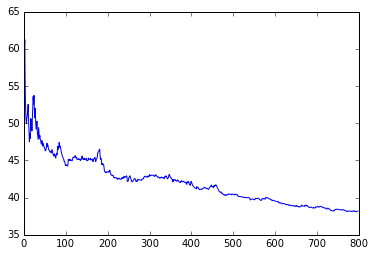

In [236]:
plot_log_loss(arr_log_loss_sgd_training)

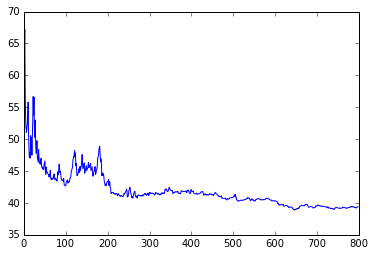

In [237]:
plot_log_loss(arr_log_loss_adf_training)

###### Validate with test set

In [34]:
start_time = time.time()

log_loss_adf_test = 0.
n_iter = 0.
n_TP = 0.
with open(train) as tit_file:
    tit_raw = DictReader(tit_file, fieldnames=header, delimiter=',');
    for t, row in enumerate(tit_raw):
        if t > 800: # Skipping header
            y = 1. if row['Survived'] == '1' else 0.
            del row['Survived']
            x = get_x_mmh3(row, D)
            #x = get_x_spooky(row, D)
            
            p = get_p_cat(x, theta_t_m)

            log_loss_adf_test += logloss(p, y)

            if t % 100 == 0 and t > 1:
                print('%s\tencountered: %d\t y=%d: %f, loss:%f' % (
                    datetime.now(), (t), y, p, loss/t))
            
            
            n_iter += 1
            if y == 1:
                if p >= 0.5:
                    n_TP += 1.
            else:
                if p < 0.5:
                    n_TP += 1.
            
            
                
            
print("---Total execution time: %s seconds ---" % (time.time() - start_time))

print("Prediction ratio: ", n_TP / n_iter)
print("log-loss: ", log_loss_adf_test)

---Total execution time: 0.0130000114441 seconds ---
('Prediction ratio: ', 0.8021978021978022)
('log-loss: ', 39.2621445387336)
